In [1]:
# Import libraries
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.functional import sigmoid, relu
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df = pd.read_csv('featurized.csv')
df_cond = pd.read_csv('featurized_condensed.csv')
df2 = pd.read_csv('featurized_2.csv')
df2_cond = pd.read_csv('featurized_condensed_2.csv')

In [3]:
df.shape, df2.shape, df_cond.shape, df2_cond.shape

((99, 532), (198, 779), (99, 365), (198, 606))

In [4]:
df = df.drop(columns=['Unnamed: 0', 'Ingredients'])
df_cond = df_cond.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Ingredients'])
df2 = df2.drop(columns=['Unnamed: 0', 'Ingredients'])
df2_cond = df2_cond.drop(columns=['Unnamed: 0', 'Ingredients'])

In [5]:
df = df.set_index('ID')
df_cond = df_cond.set_index('ID')
df2 = df2.set_index('ID')
df2_cond = df2_cond.set_index('ID')

# DF

In [6]:
cuisines = list(set(df['Cuisine']))

In [7]:
binary_cuisines = {}
counter = 0
for i in cuisines:
    length = np.zeros(len(cuisines))
    length[counter] = 1
    length = length.tolist()
    counter += 1
    binary_cuisines[i] = length

In [8]:
lists = {}
for i in df.iterrows():
    i[1][0] = binary_cuisines[i[1][0]]
    lists[i[0]] = i[1][0]+i[1][1:].get_values().tolist()

In [9]:
ncuisines = len(df['Cuisine'].unique())
print(ncuisines)
print(df['Cuisine'].unique())
nattributes = len(df.columns[1:7])
print(nattributes)
print(np.array(df.columns[1:7]))
ningredients = len(df.columns[7:])
print(ningredients)
print(df.columns[7:])

20
['thai' 'korean' 'japanese' 'cajun_creole' 'italian' 'indian' 'vietnamese'
 'jamaican' 'british' 'mexican' 'southern_us' 'chinese' 'greek' 'filipino'
 'moroccan' 'brazilian' 'irish' 'french' 'spanish' 'russian']
6
['Vegeterian (Y/N)' 'Vegan (Y/N)' 'Dessert (Y/N)' 'Spicy (Y/N)'
 'Drink (Y/N)' 'Alcohol (Y/N)']
522
Index(['corn tortillas', 'apple cider vinegar', 'baking soda',
       'soybean sprouts', 'blanched almonds', 'radishes', 'ginger',
       'garam masala', 'sweet soy sauce', 'achiote paste',
       ...
       'sea bass fillets', 'rice wine', 'orange juice', 'udon', 'ziti',
       'pitted green olives', 'spices', 'cumin', 'granny smith apples',
       'crabmeat'],
      dtype='object', length=522)


In [10]:
cuisine_names = np.array(df['Cuisine'].unique()).reshape(-1, 1)
descriptor_names = np.array(df.columns[1:7]).reshape(-1, 1)

item_names = np.append(cuisine_names, descriptor_names).reshape(-1, 1)

In [11]:
binary_df = pd.DataFrame(lists)
input_pats = binary_df.iloc[:,:ncuisines+nattributes]
input_pats = torch.tensor(np.array(input_pats),dtype=torch.float)
output_pats = binary_df.iloc[:,ncuisines+nattributes:]
output_pats = torch.tensor(np.array(output_pats),dtype=torch.float)
N = input_pats.shape[0] # number of training patterns
input_v = input_pats[0,:].numpy().astype('bool')
output_v = output_pats[0,:].numpy().astype('bool')

In [12]:
output_shape = output_pats.shape[1]

In [13]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        # TODO : YOUR CODE GOES HERE    
        
        self.i2r = nn.Linear(ncuisines+nattributes, rep_size)
        self.r2h = nn.Linear(rep_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_shape)
        #raise Exception('Replace with your code.')

    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x = x.view(-1,ncuisines+nattributes) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:ncuisines+nattributes] # input to Item Layer [B x nobj Tensor]
#         print("x item shape "+ str(x_item.shape))
        #x_rel = x[:,ncuisines:] # input to Relation Layer [B x nrel Tensor]
        # TODO : YOUR CODE GOES HERE
        
        rep = self.i2r(x_item)
        rep = relu(rep)
        #combined = torch.cat((rep, x_rel),1)
        hidden = self.r2h(rep)
        hidden = relu(hidden)
        output = self.h2o(hidden)
        output = sigmoid(output)
        #raise Exception('Replace with your code.')

        return output, hidden, rep

In [14]:
def train(mynet,epoch_count,nepochs_additional=5000):
    # Input
    #  mynet : Net class object
    #  epoch_count : (scalar) how many epochs have been completed so far
    #  nepochs_additional : (scalar) how many more epochs we want to run
    mynet.train()
    for e in range(nepochs_additional): # for each epoch
        error_epoch = 0.
        perm = np.random.permutation(N)
        for p in perm: # iterate through input patterns in random order
            mynet.zero_grad() # reset gradient
            output, hidden, rep = mynet(input_pats[p,:]) # forward pass
            target = output_pats[p,:]
            target = target.reshape(1,-1)

            loss = criterion(output, target) # compute loss
            
            loss.backward() # compute gradient 
            optimizer.step() # update network parameters
            error_epoch += loss.item()
        error_epoch = error_epoch / float(N)        
        if e % 50 == 0:
            print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,3)))
    return epoch_count + nepochs_additional

In [15]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    input_clean = torch.zeros(26,26)
    for idx,name in enumerate(item_names):
        input_clean[idx,idx] = 1. # 1-hot encoding of each object (while Relation Layer doesn't matter)
    output, hidden, rep = mynet(input_clean)
    return rep.detach().numpy()

def plot_rep(rep1, rep2, rep3, names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]

    nrows = 26
    R = np.dstack((rep1, rep2, rep3))    
    mx = R.max()
    mn = R.min()
    depth = R.shape[2]
    count = 1
    plt.figure(1,figsize=(4.2,8.4))
    for i in range(nrows):
        for d in range(R.shape[2]):
            plt.subplot(nrows, depth, count)
            rep = R[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names[i])
            if i==0:
                plt.title("epoch " + str(nepochs_list[d]))
            count += 1
    plt.show()

def plot_dendo(rep1, rep2, rep3, names, x_rotation = 0):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]
    linked1 = linkage(rep1,'single')
    linked2 = linkage(rep2,'single')
    linked3 = linkage(rep3,'single')
    mx = np.dstack((linked1[:,2], linked2[:,2], linked3[:,2])).max()+0.1    
    plt.figure(2,figsize=(20, 40))
#     plt.subplot(3,1,1)    
#     dendrogram(linked1, labels = names, color_threshold = 0)
#     plt.ylim([0,mx])
#     plt.title('Hierarchical clustering; ' + "epoch " + str(nepochs_list[0]))
#     plt.ylabel('Euclidean distance')
#     plt.subplot(3,1,2)
#     plt.title("epoch " + str(nepochs_list[1]))
#     dendrogram(linked2, labels=names, color_threshold=0)
#     plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch " + str(nepochs_list[2]))
    dendrogram(linked3, labels = names, color_threshold = 0)
    plt.xticks(rotation = x_rotation)
    plt.show()

In [16]:
learning_rate = 0.1
criterion = nn.MSELoss() # mean squared error loss function
mynet = Net(rep_size=8,hidden_size=15)
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent

nepochs_phase1 = 500
nepochs_phase2 = 1000
nepochs_phase3 = 2500
epoch_count = 0
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase1)
# rep1 = get_rep(mynet)
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase2-nepochs_phase1)
# rep2 = get_rep(mynet)
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase3-nepochs_phase2)
# rep3 = get_rep(mynet)


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 loss 0.225
epoch 50 loss 0.022
epoch 100 loss 0.022
epoch 150 loss 0.021
epoch 200 loss 0.021
epoch 250 loss 0.021
epoch 300 loss 0.021
epoch 350 loss 0.021
epoch 400 loss 0.021
epoch 450 loss 0.021
epoch 500 loss 0.021
epoch 550 loss 0.02
epoch 600 loss 0.02
epoch 650 loss 0.02
epoch 700 loss 0.02
epoch 750 loss 0.02
epoch 800 loss 0.019
epoch 850 loss 0.019
epoch 900 loss 0.019
epoch 950 loss 0.019
epoch 1000 loss 0.019
epoch 1050 loss 0.019
epoch 1100 loss 0.019
epoch 1150 loss 0.019
epoch 1200 loss 0.019
epoch 1250 loss 0.019
epoch 1300 loss 0.018
epoch 1350 loss 0.018
epoch 1400 loss 0.018
epoch 1450 loss 0.018
epoch 1500 loss 0.018
epoch 1550 loss 0.018
epoch 1600 loss 0.018
epoch 1650 loss 0.018
epoch 1700 loss 0.018
epoch 1750 loss 0.018
epoch 1800 loss 0.018
epoch 1850 loss 0.018
epoch 1900 loss 0.018
epoch 1950 loss 0.018
epoch 2000 loss 0.018
epoch 2050 loss 0.017
epoch 2100 loss 0.017
epoch 2150 loss 0.017
epoch 2200 loss 0.017
epoch 2250 loss 0.017
epoch 2300 loss 

In [17]:
rep1 = get_rep(mynet)
rep2 = get_rep(mynet)
rep3 = get_rep(mynet)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


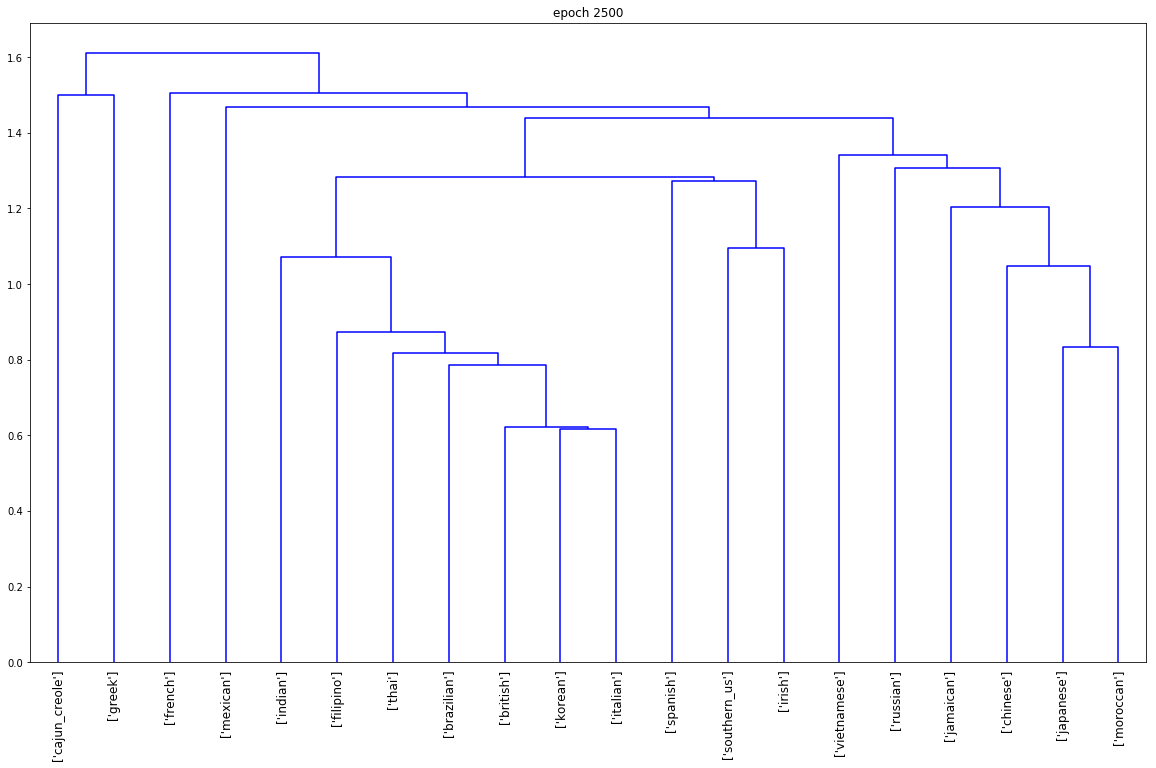

In [18]:
plot_dendo(rep1[:20], rep2[:20], rep3[:20], cuisine_names, x_rotation = 90)

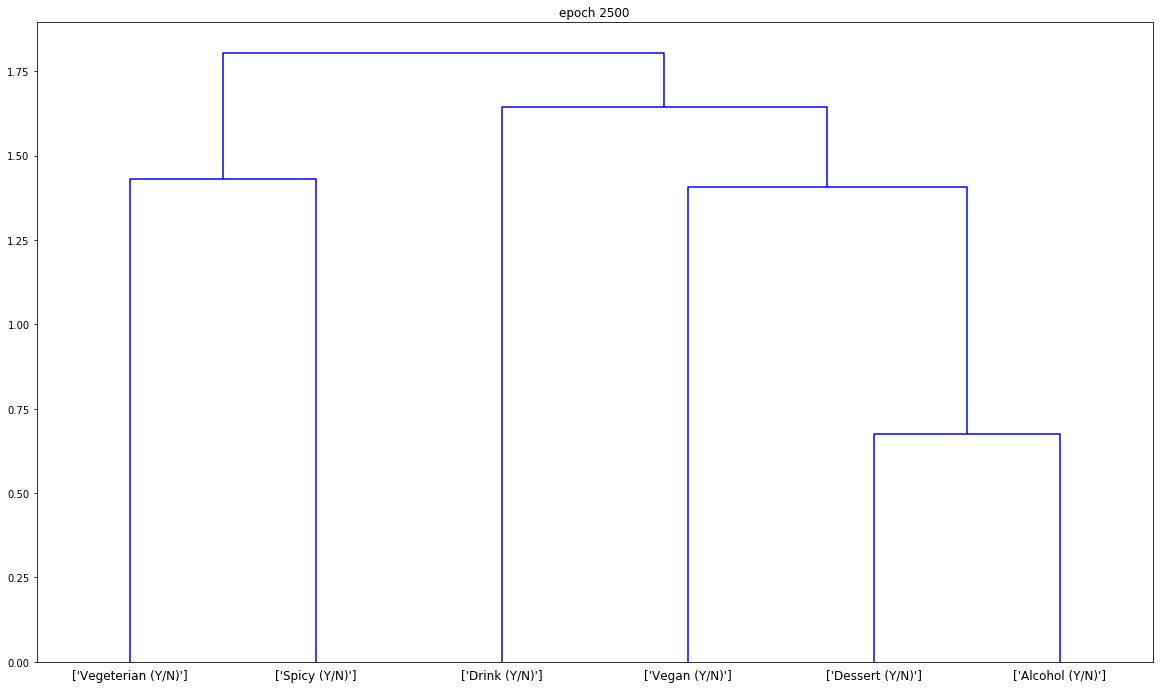

In [19]:
plot_dendo(rep1[20:], rep2[20:], rep3[20:], descriptor_names)

In [20]:
cuisine_names[5]

array(['indian'], dtype=object)

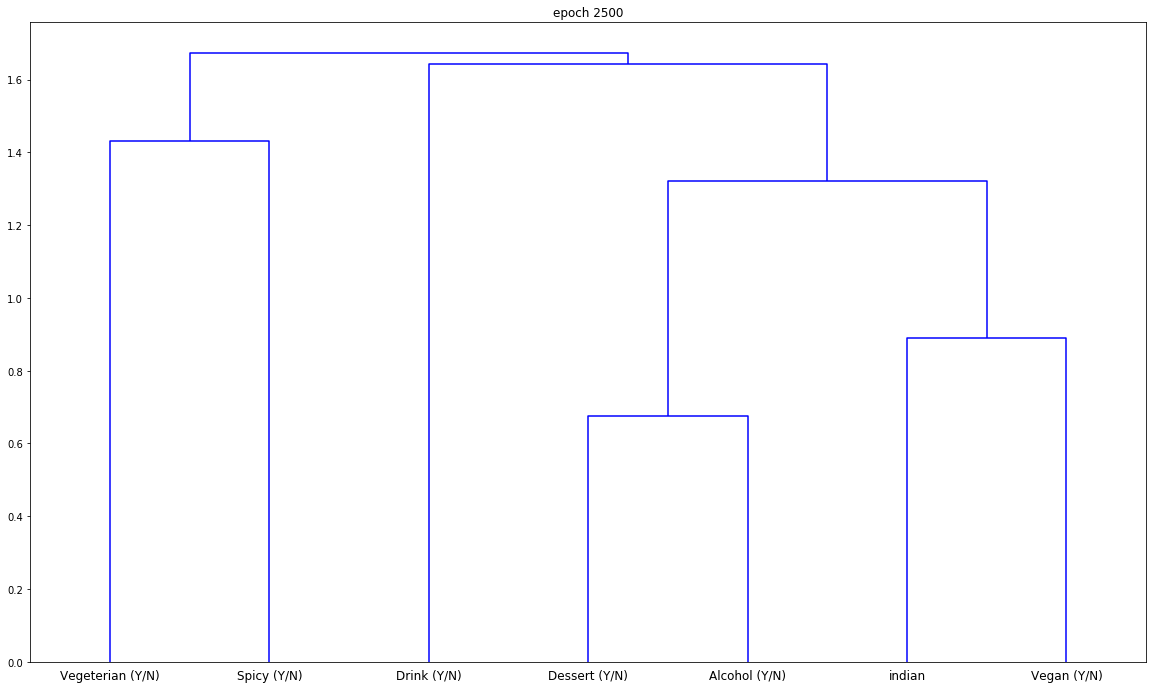

In [21]:
plot_dendo(rep1[[5, 20, 21, 22, 23, 24, 25], :], 
           rep2[[5, 20, 21, 22, 23, 24, 25], :], 
           rep3[[5, 20, 21, 22, 23, 24, 25], :], np.append(cuisine_names[5], descriptor_names))



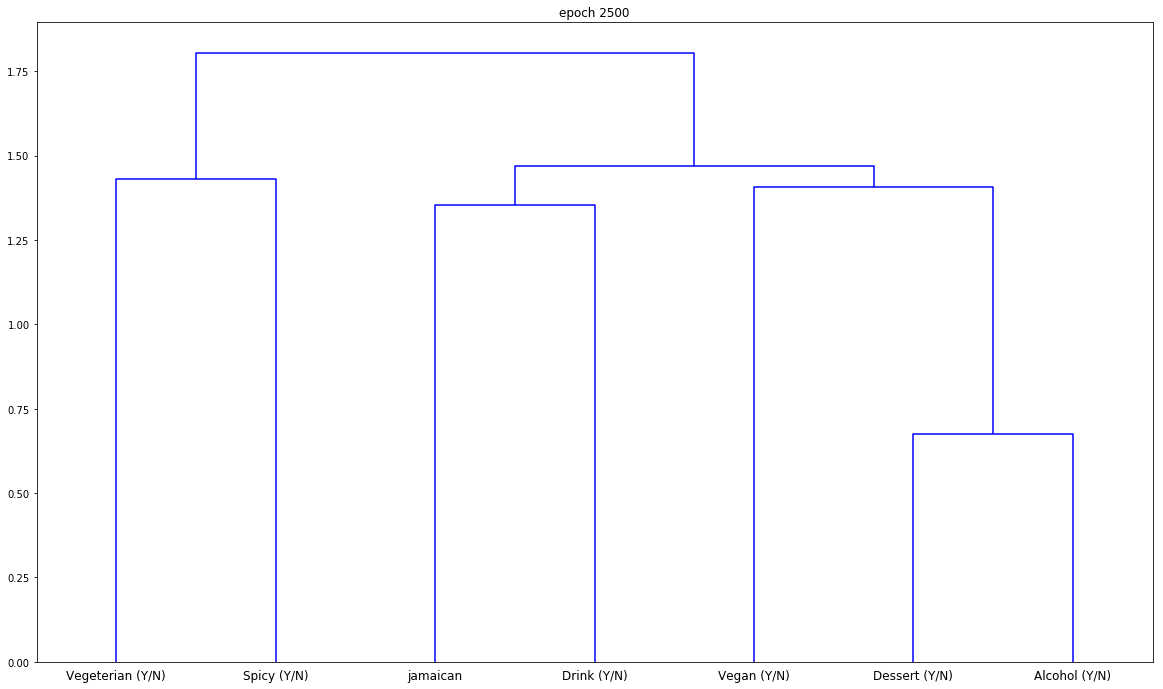

In [22]:
plot_dendo(rep1[[7, 20, 21, 22, 23, 24, 25], :], 
           rep2[[7, 20, 21, 22, 23, 24, 25], :], 
           rep3[[7, 20, 21, 22, 23, 24, 25], :], np.append(cuisine_names[7], descriptor_names))

# DF Condensed

In [23]:
cuisines = list(set(df_cond['Cuisine']))

In [24]:
binary_cuisines = {}
counter = 0
for i in cuisines:
    length = np.zeros(len(cuisines))
    length[counter] = 1
    length = length.tolist()
    counter += 1
    binary_cuisines[i] = length

In [25]:
lists = {}
for i in df_cond.iterrows():
    i[1][0] = binary_cuisines[i[1][0]]
    lists[i[0]] = i[1][0]+i[1][1:].get_values().tolist()

In [26]:
ncuisines = len(df_cond['Cuisine'].unique())
print(ncuisines)
print(df_cond['Cuisine'].unique())
nattributes = len(df_cond.columns[1:7])
print(nattributes)
print(np.array(df_cond.columns[1:7]))
ningredients = len(df_cond.columns[7:])
print(ningredients)
print(df_cond.columns[7:])

20
['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']
6
['veg' 'vegan' 'dessert' 'spicy' 'drink' 'alcohol']
354
Index(['Unnamed: 11', 'grated parmesan cheese', 'Italian Dressing',
       'baking powder', 'active  yeast', 'onions', ' almonds', 'chili powder',
       'red curry paste', 'cumin',
       ...
       'oregano', 'sweet potato', 'celery ribs', 'chili', 'cardamom',
       'bouillon cube', 'corn tortillas', 'cauliflower', 'spices',
       'corn syrup'],
      dtype='object', length=354)


In [27]:
cuisine_names = np.array(df_cond['Cuisine'].unique()).reshape(-1, 1)
descriptor_names = np.array(df_cond.columns[1:7]).reshape(-1, 1)

item_names = np.append(cuisine_names, descriptor_names).reshape(-1, 1)

In [28]:
binary_df = pd.DataFrame(lists)
input_pats = binary_df.iloc[:,:ncuisines+nattributes]
input_pats = torch.tensor(np.array(input_pats),dtype=torch.float)
output_pats = binary_df.iloc[:,ncuisines+nattributes:]
output_pats = torch.tensor(np.array(output_pats),dtype=torch.float)
N = input_pats.shape[0] # number of training patterns
input_v = input_pats[0,:].numpy().astype('bool')
output_v = output_pats[0,:].numpy().astype('bool')

In [29]:
output_shape = output_pats.shape[1]

In [30]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        # TODO : YOUR CODE GOES HERE    
        
        self.i2r = nn.Linear(ncuisines+nattributes, rep_size)
        self.r2h = nn.Linear(rep_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_shape)
        #raise Exception('Replace with your code.')

    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x = x.view(-1,ncuisines+nattributes) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:ncuisines+nattributes] # input to Item Layer [B x nobj Tensor]
#         print("x item shape "+ str(x_item.shape))
        #x_rel = x[:,ncuisines:] # input to Relation Layer [B x nrel Tensor]
        # TODO : YOUR CODE GOES HERE
        
        rep = self.i2r(x_item)
        rep = relu(rep)
        #combined = torch.cat((rep, x_rel),1)
        hidden = self.r2h(rep)
        hidden = relu(hidden)
        output = self.h2o(hidden)
        output = sigmoid(output)
        #raise Exception('Replace with your code.')

        return output, hidden, rep

In [31]:
def train(mynet,epoch_count,nepochs_additional=5000):
    # Input
    #  mynet : Net class object
    #  epoch_count : (scalar) how many epochs have been completed so far
    #  nepochs_additional : (scalar) how many more epochs we want to run
    mynet.train()
    for e in range(nepochs_additional): # for each epoch
        error_epoch = 0.
        perm = np.random.permutation(N)
        for p in perm: # iterate through input patterns in random order
            mynet.zero_grad() # reset gradient
            output, hidden, rep = mynet(input_pats[p,:]) # forward pass
            target = output_pats[p,:] 
            target = target.reshape(1,-1)
    
            loss = criterion(output, target) # compute loss
            
            loss.backward() # compute gradient 
            optimizer.step() # update network parameters
            error_epoch += loss.item()
        error_epoch = error_epoch / float(N)        
        if e % 50 == 0:
            print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,3)))
    return epoch_count + nepochs_additional

In [32]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    input_clean = torch.zeros(26,26)
    for idx,name in enumerate(item_names):
        input_clean[idx,idx] = 1. # 1-hot encoding of each object (while Relation Layer doesn't matter)
    output, hidden, rep = mynet(input_clean)
    return rep.detach().numpy()

def plot_rep(rep1, rep2, rep3, names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]

    nrows = 26
    R = np.dstack((rep1, rep2, rep3))    
    mx = R.max()
    mn = R.min()
    depth = R.shape[2]
    count = 1
    plt.figure(1,figsize=(4.2,8.4))
    for i in range(nrows):
        for d in range(R.shape[2]):
            plt.subplot(nrows, depth, count)
            rep = R[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names[i])
            if i==0:
                plt.title("epoch " + str(nepochs_list[d]))
            count += 1
    plt.show()

def plot_dendo(rep1, rep2, rep3, names, x_rotation = 0):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]
    linked1 = linkage(rep1,'single')
    linked2 = linkage(rep2,'single')
    linked3 = linkage(rep3,'single')
    mx = np.dstack((linked1[:,2], linked2[:,2], linked3[:,2])).max()+0.1    
    plt.figure(2,figsize=(20, 40))
#     plt.subplot(3,1,1)    
#     dendrogram(linked1, labels = names, color_threshold = 0)
#     plt.ylim([0,mx])
#     plt.title('Hierarchical clustering; ' + "epoch " + str(nepochs_list[0]))
#     plt.ylabel('Euclidean distance')
#     plt.subplot(3,1,2)
#     plt.title("epoch " + str(nepochs_list[1]))
#     dendrogram(linked2, labels=names, color_threshold=0)
#     plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch " + str(nepochs_list[2]))
    dendrogram(linked3, labels = names, color_threshold = 0)
    plt.xticks(rotation = x_rotation)
    plt.show()

In [33]:
learning_rate = 0.1
criterion = nn.MSELoss() # mean squared error loss function
mynet = Net(rep_size=8,hidden_size=15)
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent

nepochs_phase1 = 500
nepochs_phase2 = 1000
nepochs_phase3 = 2500
epoch_count = 0
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase1)
# rep1 = get_rep(mynet)
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase2-nepochs_phase1)
# rep2 = get_rep(mynet)
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase3-nepochs_phase2)
# rep3 = get_rep(mynet)


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 loss 0.227
epoch 50 loss 0.031
epoch 100 loss 0.031
epoch 150 loss 0.031
epoch 200 loss 0.03
epoch 250 loss 0.03
epoch 300 loss 0.03
epoch 350 loss 0.03
epoch 400 loss 0.029
epoch 450 loss 0.029
epoch 500 loss 0.029
epoch 550 loss 0.028
epoch 600 loss 0.028
epoch 650 loss 0.028
epoch 700 loss 0.028
epoch 750 loss 0.028
epoch 800 loss 0.028
epoch 850 loss 0.028
epoch 900 loss 0.028
epoch 950 loss 0.027
epoch 1000 loss 0.027
epoch 1050 loss 0.027
epoch 1100 loss 0.027
epoch 1150 loss 0.027
epoch 1200 loss 0.027
epoch 1250 loss 0.026
epoch 1300 loss 0.026
epoch 1350 loss 0.026
epoch 1400 loss 0.026
epoch 1450 loss 0.026
epoch 1500 loss 0.026
epoch 1550 loss 0.026
epoch 1600 loss 0.025
epoch 1650 loss 0.025
epoch 1700 loss 0.025
epoch 1750 loss 0.025
epoch 1800 loss 0.025
epoch 1850 loss 0.025
epoch 1900 loss 0.025
epoch 1950 loss 0.025
epoch 2000 loss 0.025
epoch 2050 loss 0.024
epoch 2100 loss 0.024
epoch 2150 loss 0.024
epoch 2200 loss 0.024
epoch 2250 loss 0.024
epoch 2300 loss

In [34]:
rep1 = get_rep(mynet)
rep2 = get_rep(mynet)
rep3 = get_rep(mynet)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


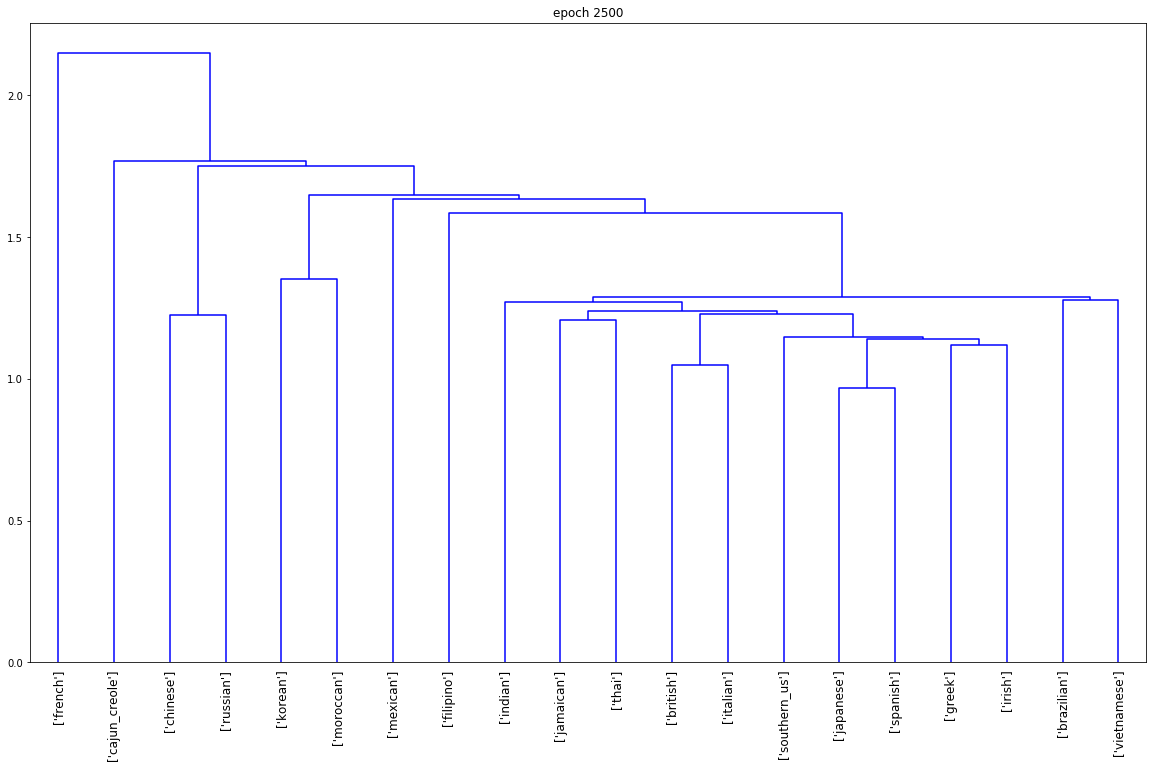

In [35]:
plot_dendo(rep1[:20], rep2[:20], rep3[:20], cuisine_names, x_rotation = 90)

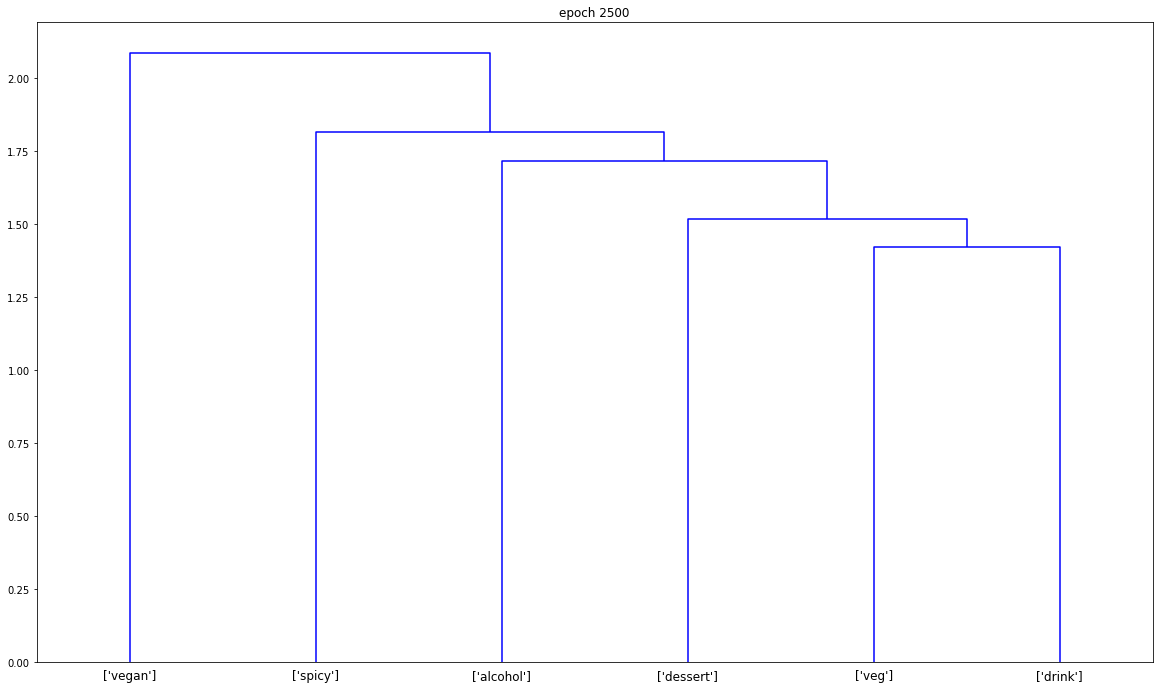

In [36]:
plot_dendo(rep1[20:], rep2[20:], rep3[20:], descriptor_names)

In [37]:
cuisine_names[5]

array(['french'], dtype=object)

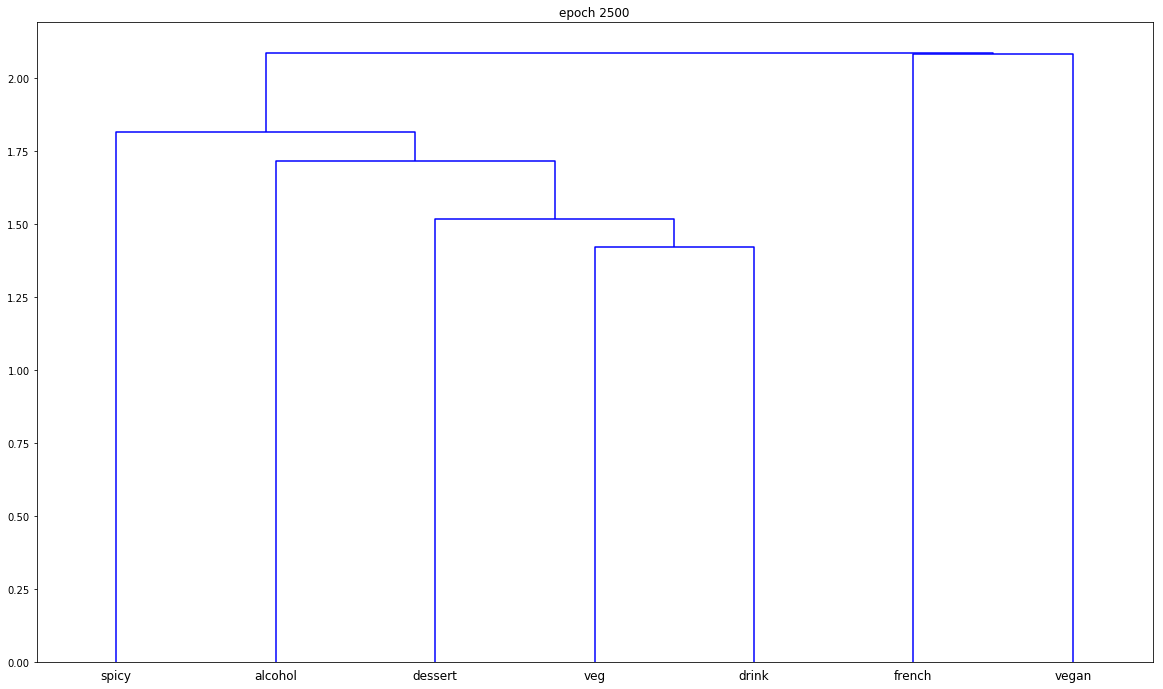

In [38]:
plot_dendo(rep1[[5, 20, 21, 22, 23, 24, 25], :], 
           rep2[[5, 20, 21, 22, 23, 24, 25], :], 
           rep3[[5, 20, 21, 22, 23, 24, 25], :], np.append(cuisine_names[5], descriptor_names))



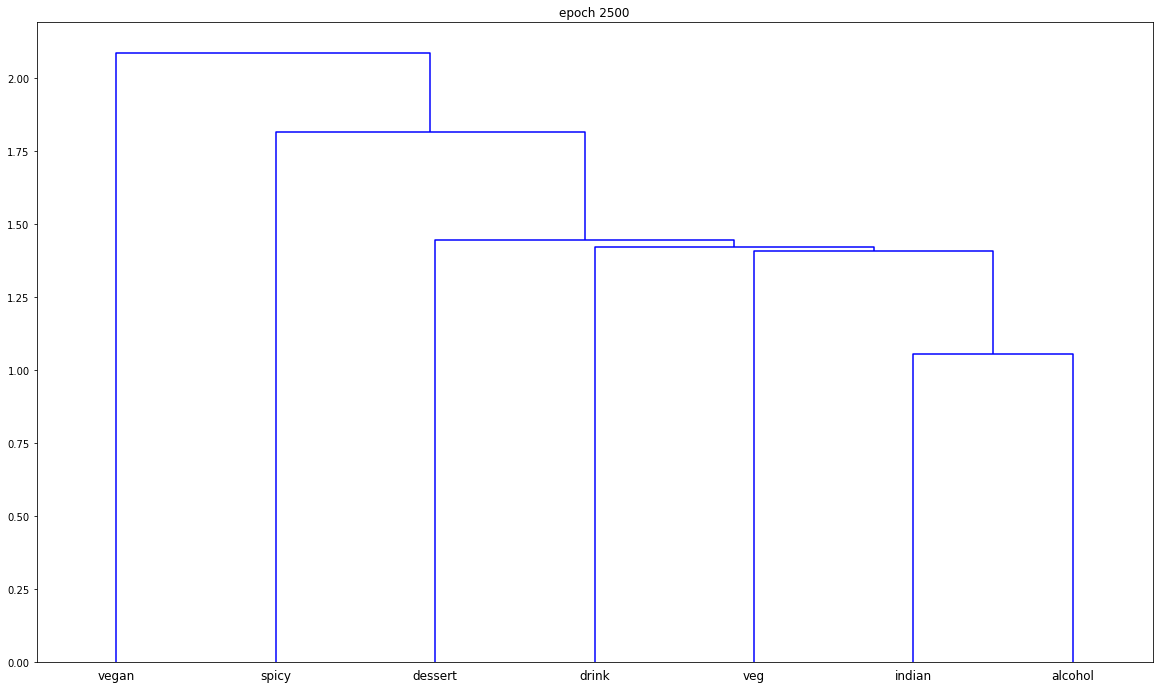

In [39]:
plot_dendo(rep1[[7, 20, 21, 22, 23, 24, 25], :], 
           rep2[[7, 20, 21, 22, 23, 24, 25], :], 
           rep3[[7, 20, 21, 22, 23, 24, 25], :], np.append(cuisine_names[7], descriptor_names))

# DF2

In [40]:
cuisines = list(set(df2['Cuisine']))

In [41]:
binary_cuisines = {}
counter = 0
for i in cuisines:
    length = np.zeros(len(cuisines))
    length[counter] = 1
    length = length.tolist()
    counter += 1
    binary_cuisines[i] = length

In [42]:
lists = {}
for i in df2.iterrows():
    i[1][0] = binary_cuisines[i[1][0]]
    lists[i[0]] = i[1][0]+i[1][1:].get_values().tolist()

In [43]:
ncuisines = len(df2['Cuisine'].unique())
print(ncuisines)
print(df2['Cuisine'].unique())
nattributes = len(df2.columns[1:7])
print(nattributes)
print(np.array(df2.columns[1:7]))
ningredients = len(df2.columns[7:])
print(ningredients)
print(df2.columns[7:])

20
['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']
6
['veg' 'vegan' 'dessert' 'spicy' 'drink' 'alcohol']
769
Index(['brandy', 'grated lemon zest', 'boiling onions', 'ground almonds',
       'ginkgo nut', 'chorizo', 'whole wheat penne pasta', 'fresh green bean',
       'lentils', 'jamaican jerk season',
       ...
       'mandarin orange segments', 'peeled prawns', 'curry paste',
       'low-fat buttermilk', 'thai basil', 'leg of lamb', 'bacon fat',
       'fresh dates', 'hot sauce', 'crushed tomatoes'],
      dtype='object', length=769)


In [44]:
cuisine_names = np.array(df2['Cuisine'].unique()).reshape(-1, 1)
descriptor_names = np.array(df2.columns[1:7]).reshape(-1, 1)

item_names = np.append(cuisine_names, descriptor_names).reshape(-1, 1)

In [45]:
binary_df = pd.DataFrame(lists)
input_pats = binary_df.iloc[:,:ncuisines+nattributes]
input_pats = torch.tensor(np.array(input_pats),dtype=torch.float)
output_pats = binary_df.iloc[:,ncuisines+nattributes:]
output_pats = torch.tensor(np.array(output_pats),dtype=torch.float)
N = input_pats.shape[0] # number of training patterns
input_v = input_pats[0,:].numpy().astype('bool')
output_v = output_pats[0,:].numpy().astype('bool')

In [46]:
output_shape = output_pats.shape[1]

In [47]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        # TODO : YOUR CODE GOES HERE    
        
        self.i2r = nn.Linear(ncuisines+nattributes, rep_size)
        self.r2h = nn.Linear(rep_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_shape)
        #raise Exception('Replace with your code.')

    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x = x.view(-1,ncuisines+nattributes) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:ncuisines+nattributes] # input to Item Layer [B x nobj Tensor]
#         print("x item shape "+ str(x_item.shape))
        #x_rel = x[:,ncuisines:] # input to Relation Layer [B x nrel Tensor]
        # TODO : YOUR CODE GOES HERE
        
        rep = self.i2r(x_item)
        rep = relu(rep)
        #combined = torch.cat((rep, x_rel),1)
        hidden = self.r2h(rep)
        hidden = relu(hidden)
        output = self.h2o(hidden)
        output = sigmoid(output)
        #raise Exception('Replace with your code.')

        return output, hidden, rep

In [48]:
def train(mynet,epoch_count,nepochs_additional=5000):
    # Input
    #  mynet : Net class object
    #  epoch_count : (scalar) how many epochs have been completed so far
    #  nepochs_additional : (scalar) how many more epochs we want to run
    mynet.train()
    for e in range(nepochs_additional): # for each epoch
        error_epoch = 0.
        perm = np.random.permutation(N)
        for p in perm: # iterate through input patterns in random order
            mynet.zero_grad() # reset gradient
            output, hidden, rep = mynet(input_pats[p,:]) # forward pass
            target = output_pats[p,:] 
            target = target.reshape(1,-1)
    
            loss = criterion(output, target) # compute loss
            
            loss.backward() # compute gradient 
            optimizer.step() # update network parameters
            error_epoch += loss.item()
        error_epoch = error_epoch / float(N)        
        if e % 50 == 0:
            print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,3)))
    return epoch_count + nepochs_additional

In [49]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    input_clean = torch.zeros(26,26)
    for idx,name in enumerate(item_names):
        input_clean[idx,idx] = 1. # 1-hot encoding of each object (while Relation Layer doesn't matter)
    output, hidden, rep = mynet(input_clean)
    return rep.detach().numpy()

def plot_rep(rep1, rep2, rep3, names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]

    nrows = 26
    R = np.dstack((rep1, rep2, rep3))    
    mx = R.max()
    mn = R.min()
    depth = R.shape[2]
    count = 1
    plt.figure(1,figsize=(4.2,8.4))
    for i in range(nrows):
        for d in range(R.shape[2]):
            plt.subplot(nrows, depth, count)
            rep = R[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names[i])
            if i==0:
                plt.title("epoch " + str(nepochs_list[d]))
            count += 1
    plt.show()

def plot_dendo(rep1, rep2, rep3, names, x_rotation = 0):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]
    linked1 = linkage(rep1,'single')
    linked2 = linkage(rep2,'single')
    linked3 = linkage(rep3,'single')
    mx = np.dstack((linked1[:,2], linked2[:,2], linked3[:,2])).max()+0.1    
    plt.figure(2,figsize=(20, 40))
#     plt.subplot(3,1,1)    
#     dendrogram(linked1, labels = names, color_threshold = 0)
#     plt.ylim([0,mx])
#     plt.title('Hierarchical clustering; ' + "epoch " + str(nepochs_list[0]))
#     plt.ylabel('Euclidean distance')
#     plt.subplot(3,1,2)
#     plt.title("epoch " + str(nepochs_list[1]))
#     dendrogram(linked2, labels=names, color_threshold=0)
#     plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch " + str(nepochs_list[2]))
    dendrogram(linked3, labels = names, color_threshold = 0)
    plt.xticks(rotation = x_rotation)
    plt.show()

In [50]:
learning_rate = 0.1
criterion = nn.MSELoss() # mean squared error loss function
mynet = Net(rep_size=8,hidden_size=15)
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent

nepochs_phase1 = 500
nepochs_phase2 = 1000
nepochs_phase3 = 2500
epoch_count = 0
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase1)
# rep1 = get_rep(mynet)
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase2-nepochs_phase1)
# rep2 = get_rep(mynet)
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase3-nepochs_phase2)
# rep3 = get_rep(mynet)


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 loss 0.229
epoch 50 loss 0.016
epoch 100 loss 0.016
epoch 150 loss 0.016
epoch 200 loss 0.016
epoch 250 loss 0.016
epoch 300 loss 0.016
epoch 350 loss 0.016
epoch 400 loss 0.015
epoch 450 loss 0.015
epoch 500 loss 0.015
epoch 550 loss 0.015
epoch 600 loss 0.015
epoch 650 loss 0.015
epoch 700 loss 0.015
epoch 750 loss 0.015
epoch 800 loss 0.015
epoch 850 loss 0.015
epoch 900 loss 0.015
epoch 950 loss 0.015
epoch 1000 loss 0.015
epoch 1050 loss 0.015
epoch 1100 loss 0.015
epoch 1150 loss 0.015
epoch 1200 loss 0.015
epoch 1250 loss 0.015
epoch 1300 loss 0.015
epoch 1350 loss 0.015
epoch 1400 loss 0.015
epoch 1450 loss 0.015
epoch 1500 loss 0.015
epoch 1550 loss 0.014
epoch 1600 loss 0.014
epoch 1650 loss 0.014
epoch 1700 loss 0.014
epoch 1750 loss 0.014
epoch 1800 loss 0.014
epoch 1850 loss 0.014
epoch 1900 loss 0.014
epoch 1950 loss 0.014
epoch 2000 loss 0.014
epoch 2050 loss 0.014
epoch 2100 loss 0.014
epoch 2150 loss 0.014
epoch 2200 loss 0.014
epoch 2250 loss 0.014
epoch 2300 

In [51]:
rep1 = get_rep(mynet)
rep2 = get_rep(mynet)
rep3 = get_rep(mynet)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


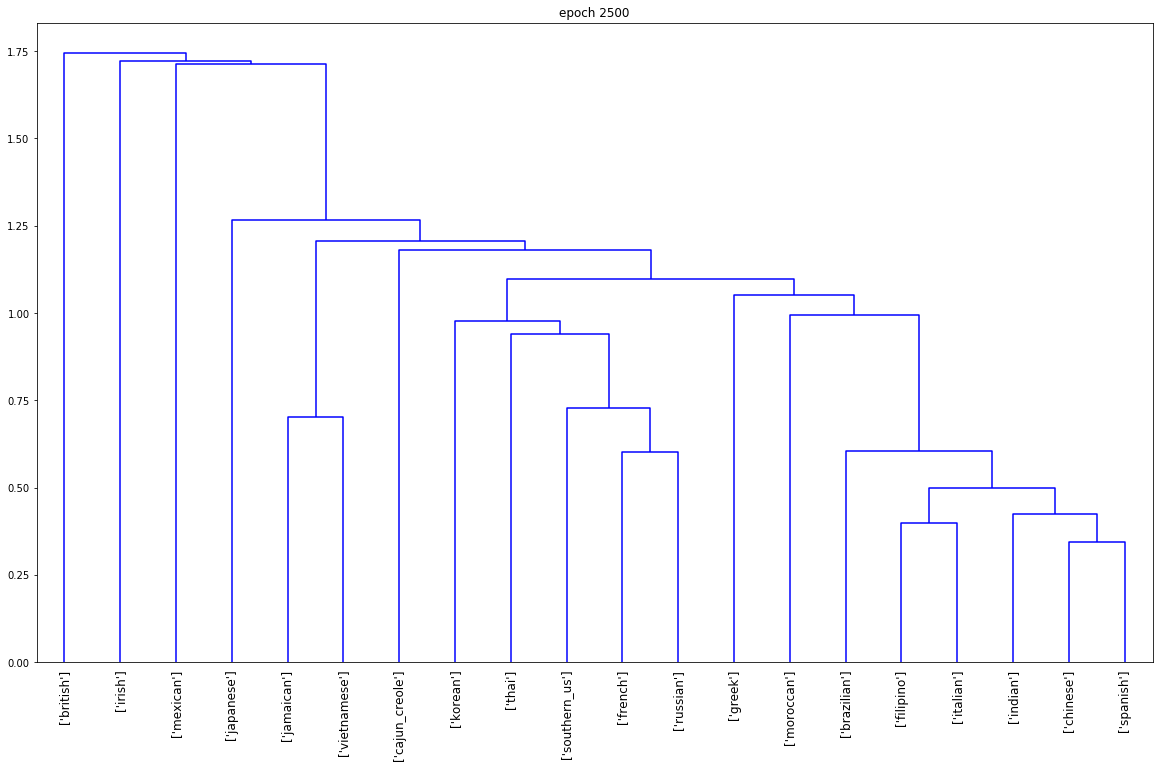

In [52]:
plot_dendo(rep1[:20], rep2[:20], rep3[:20], cuisine_names, x_rotation = 90)

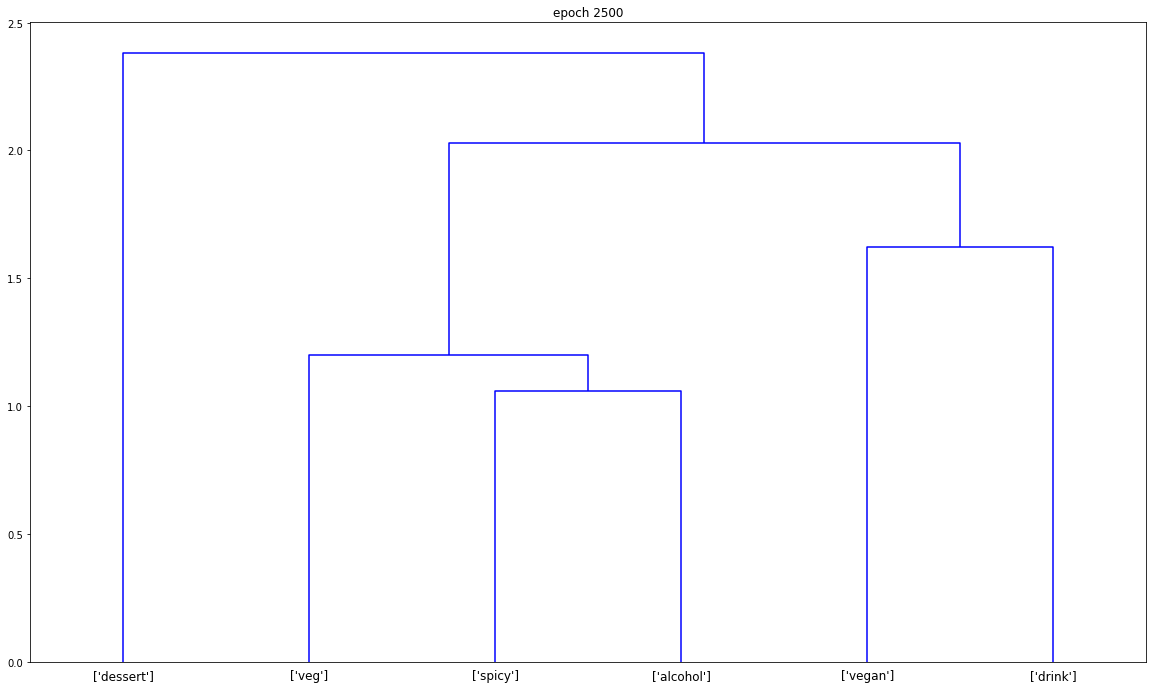

In [53]:
plot_dendo(rep1[20:], rep2[20:], rep3[20:], descriptor_names)

In [54]:
cuisine_names[5]

array(['french'], dtype=object)

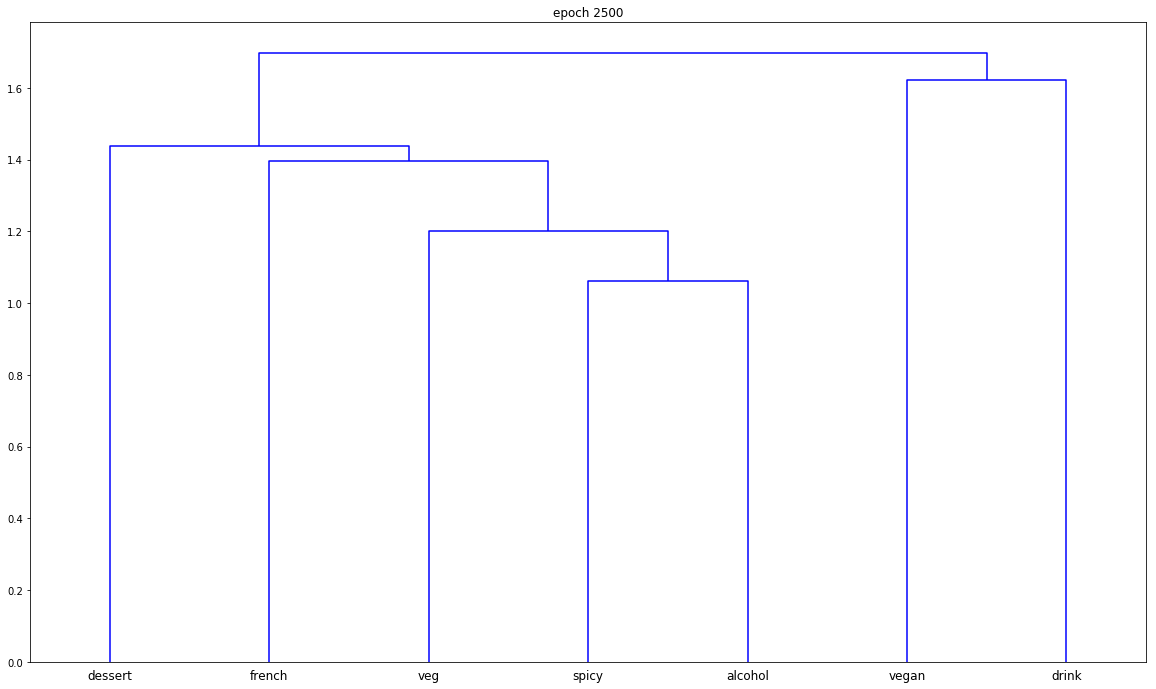

In [55]:
plot_dendo(rep1[[5, 20, 21, 22, 23, 24, 25], :], 
           rep2[[5, 20, 21, 22, 23, 24, 25], :], 
           rep3[[5, 20, 21, 22, 23, 24, 25], :], np.append(cuisine_names[5], descriptor_names))



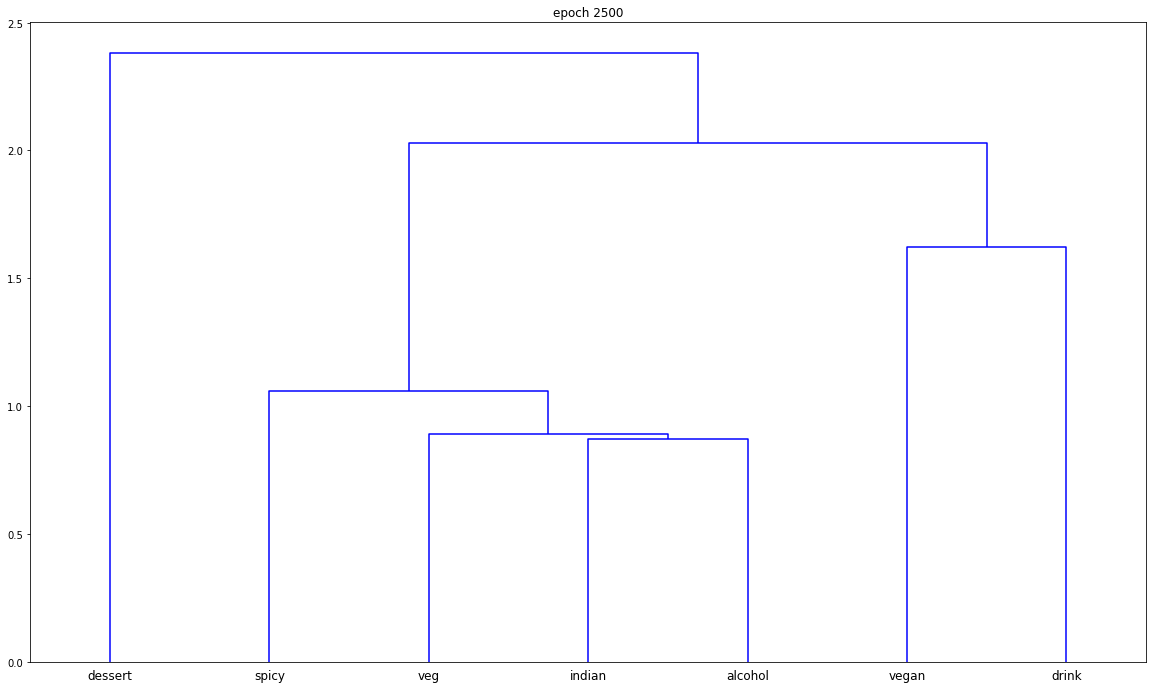

In [56]:
plot_dendo(rep1[[7, 20, 21, 22, 23, 24, 25], :], 
           rep2[[7, 20, 21, 22, 23, 24, 25], :], 
           rep3[[7, 20, 21, 22, 23, 24, 25], :], np.append(cuisine_names[7], descriptor_names))

# DF2 Condensed

In [57]:
cuisines = list(set(df2_cond['Cuisine']))

In [58]:
binary_cuisines = {}
counter = 0
for i in cuisines:
    length = np.zeros(len(cuisines))
    length[counter] = 1
    length = length.tolist()
    counter += 1
    binary_cuisines[i] = length

In [59]:
lists = {}
for i in df2_cond.iterrows():
    i[1][0] = binary_cuisines[i[1][0]]
    lists[i[0]] = i[1][0]+i[1][1:].get_values().tolist()

In [60]:
ncuisines = len(df2_cond['Cuisine'].unique())
print(ncuisines)
print(df2_cond['Cuisine'].unique())
nattributes = len(df2_cond.columns[1:7])
print(nattributes)
print(np.array(df2_cond.columns[1:7]))
ningredients = len(df2_cond.columns[7:])
print(ningredients)
print(df2_cond.columns[7:])

20
['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']
6
['veg' 'vegan' 'dessert' 'spicy' 'drink' 'alcohol']
596
Index(['Unnamed: 10', 'grated parmesan cheese', 'Italian Dressing', 'browning',
       'baking powder', 'chili ', 'sunflower kernels', 'active  yeast',
       'onions', ' almonds',
       ...
       'chili', 'cardamom', 'bouillon cube', '  mint', 'ginger ',
       'corn tortillas', 'cauliflower', ' thyme', 'spices', 'corn syrup'],
      dtype='object', length=596)


In [61]:
cuisine_names = np.array(df2_cond['Cuisine'].unique()).reshape(-1, 1)
descriptor_names = np.array(df2_cond.columns[1:7]).reshape(-1, 1)

item_names = np.append(cuisine_names, descriptor_names).reshape(-1, 1)

In [62]:
binary_df = pd.DataFrame(lists)
input_pats = binary_df.iloc[:,:ncuisines+nattributes]
input_pats = torch.tensor(np.array(input_pats),dtype=torch.float)
output_pats = binary_df.iloc[:,ncuisines+nattributes:]
output_pats = torch.tensor(np.array(output_pats),dtype=torch.float)
N = input_pats.shape[0] # number of training patterns
input_v = input_pats[0,:].numpy().astype('bool')
output_v = output_pats[0,:].numpy().astype('bool')

In [63]:
output_shape = output_pats.shape[1]

In [64]:
class Net(nn.Module):
    def __init__(self, rep_size, hidden_size):
        super(Net, self).__init__()
        # Input
        #  rep_size : number of hidden units in "Representation Layer"
        #  hidden_Size : number of hidden units in "Hidden Layer"
        #
        # TODO : YOUR CODE GOES HERE    
        
        self.i2r = nn.Linear(ncuisines+nattributes, rep_size)
        self.r2h = nn.Linear(rep_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_shape)
        #raise Exception('Replace with your code.')

    def forward(self, x):
        # Defines forward pass for the network on input patterns x
        #
        # Input can take these two forms:
        #
        #   x: [nobj+nrel 1D Tensor], which is a single input pattern as a 1D tensor
        #      (containing both object and relation 1-hot identifier) (batch size is B=1)
        #   OR
        #   x : [B x (nobj+nrel) Tensor], which is a batch of B input patterns (one for each row)
        #
        # Output
        #   output [B x nattribute Tensor], which is the output pattern for each input pattern B on the Attribute Layer
        #   hidden [B x hidden_size Tensor], which are activations in the Hidden Layer
        #   rep [B x rep_size Tensor], which are the activations in the Representation LAyer
        x = x.view(-1,ncuisines+nattributes) # reshape as size [B x (nobj+nrel) Tensor] if B=1
        x_item = x[:,:ncuisines+nattributes] # input to Item Layer [B x nobj Tensor]
#         print("x item shape "+ str(x_item.shape))
        #x_rel = x[:,ncuisines:] # input to Relation Layer [B x nrel Tensor]
        # TODO : YOUR CODE GOES HERE
        
        rep = self.i2r(x_item)
        rep = relu(rep)
        #combined = torch.cat((rep, x_rel),1)
        hidden = self.r2h(rep)
        hidden = relu(hidden)
        output = self.h2o(hidden)
        output = sigmoid(output)
        #raise Exception('Replace with your code.')

        return output, hidden, rep

In [65]:
def train(mynet,epoch_count,nepochs_additional=5000):
    # Input
    #  mynet : Net class object
    #  epoch_count : (scalar) how many epochs have been completed so far
    #  nepochs_additional : (scalar) how many more epochs we want to run
    mynet.train()
    for e in range(nepochs_additional): # for each epoch
        error_epoch = 0.
        perm = np.random.permutation(N)
        for p in perm: # iterate through input patterns in random order
            mynet.zero_grad() # reset gradient
            output, hidden, rep = mynet(input_pats[p,:]) # forward pass
            target = output_pats[p,:] 
            target = target.reshape(1,-1)
    
            loss = criterion(output, target) # compute loss
            
            loss.backward() # compute gradient 
            optimizer.step() # update network parameters
            error_epoch += loss.item()
        error_epoch = error_epoch / float(N)        
        if e % 50 == 0:
            print('epoch ' + str(epoch_count+e) + ' loss ' + str(round(error_epoch,3)))
    return epoch_count + nepochs_additional

In [66]:
def get_rep(net):
    # Extract the hidden activations on the Representation Layer for each item
    # 
    # Input
    #  net : Net class object
    #
    # Output
    #  rep : [nitem x rep_size numpy array], where each row is an item
    input_clean = torch.zeros(26,26)
    for idx,name in enumerate(item_names):
        input_clean[idx,idx] = 1. # 1-hot encoding of each object (while Relation Layer doesn't matter)
    output, hidden, rep = mynet(input_clean)
    return rep.detach().numpy()

def plot_rep(rep1, rep2, rep3, names):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using bar graphs
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]

    nrows = 26
    R = np.dstack((rep1, rep2, rep3))    
    mx = R.max()
    mn = R.min()
    depth = R.shape[2]
    count = 1
    plt.figure(1,figsize=(4.2,8.4))
    for i in range(nrows):
        for d in range(R.shape[2]):
            plt.subplot(nrows, depth, count)
            rep = R[i,:,d]
            plt.bar(range(rep.size),rep)
            plt.ylim([mn,mx])
            plt.xticks([])
            plt.yticks([])        
            if d==0:
                plt.ylabel(names[i])
            if i==0:
                plt.title("epoch " + str(nepochs_list[d]))
            count += 1
    plt.show()

def plot_dendo(rep1, rep2, rep3, names, x_rotation = 0):
    #  Compares Representation Layer activations of Items at three different times points in learning (rep1, rep2, rep3)
    #  using hierarchical clustering
    # 
    #  Each rep1, rep2, rep3 is a [nitem x rep_size numpy array]
    #  names : [nitem list] of item names
    #
    nepochs_list = [nepochs_phase1, nepochs_phase2, nepochs_phase3]
    linked1 = linkage(rep1,'single')
    linked2 = linkage(rep2,'single')
    linked3 = linkage(rep3,'single')
    mx = np.dstack((linked1[:,2], linked2[:,2], linked3[:,2])).max()+0.1    
    plt.figure(2,figsize=(20, 40))
#     plt.subplot(3,1,1)    
#     dendrogram(linked1, labels = names, color_threshold = 0)
#     plt.ylim([0,mx])
#     plt.title('Hierarchical clustering; ' + "epoch " + str(nepochs_list[0]))
#     plt.ylabel('Euclidean distance')
#     plt.subplot(3,1,2)
#     plt.title("epoch " + str(nepochs_list[1]))
#     dendrogram(linked2, labels=names, color_threshold=0)
#     plt.ylim([0,mx])
    plt.subplot(3,1,3)
    plt.title("epoch " + str(nepochs_list[2]))
    dendrogram(linked3, labels = names, color_threshold = 0)
    plt.xticks(rotation = x_rotation)
    plt.show()

In [67]:
learning_rate = 0.1
criterion = nn.MSELoss() # mean squared error loss function
mynet = Net(rep_size=8,hidden_size=15)
optimizer = torch.optim.SGD(mynet.parameters(), lr=learning_rate) # stochastic gradient descent

nepochs_phase1 = 500
nepochs_phase2 = 1000
nepochs_phase3 = 2500
epoch_count = 0
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase1)
# rep1 = get_rep(mynet)
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase2-nepochs_phase1)
# rep2 = get_rep(mynet)
epoch_count = train(mynet, epoch_count, nepochs_additional = nepochs_phase3-nepochs_phase2)
# rep3 = get_rep(mynet)


/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 loss 0.23
epoch 50 loss 0.02
epoch 100 loss 0.02
epoch 150 loss 0.019
epoch 200 loss 0.019
epoch 250 loss 0.019
epoch 300 loss 0.019
epoch 350 loss 0.019
epoch 400 loss 0.019
epoch 450 loss 0.019
epoch 500 loss 0.019
epoch 550 loss 0.019
epoch 600 loss 0.019
epoch 650 loss 0.019
epoch 700 loss 0.018
epoch 750 loss 0.018
epoch 800 loss 0.018
epoch 850 loss 0.018
epoch 900 loss 0.018
epoch 950 loss 0.018
epoch 1000 loss 0.018
epoch 1050 loss 0.018
epoch 1100 loss 0.018
epoch 1150 loss 0.017
epoch 1200 loss 0.017
epoch 1250 loss 0.017
epoch 1300 loss 0.017
epoch 1350 loss 0.017
epoch 1400 loss 0.017
epoch 1450 loss 0.017
epoch 1500 loss 0.017
epoch 1550 loss 0.017
epoch 1600 loss 0.017
epoch 1650 loss 0.017
epoch 1700 loss 0.017
epoch 1750 loss 0.017
epoch 1800 loss 0.017
epoch 1850 loss 0.017
epoch 1900 loss 0.017
epoch 1950 loss 0.017
epoch 2000 loss 0.016
epoch 2050 loss 0.016
epoch 2100 loss 0.016
epoch 2150 loss 0.016
epoch 2200 loss 0.016
epoch 2250 loss 0.016
epoch 2300 los

In [68]:
rep1 = get_rep(mynet)
rep2 = get_rep(mynet)
rep3 = get_rep(mynet)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


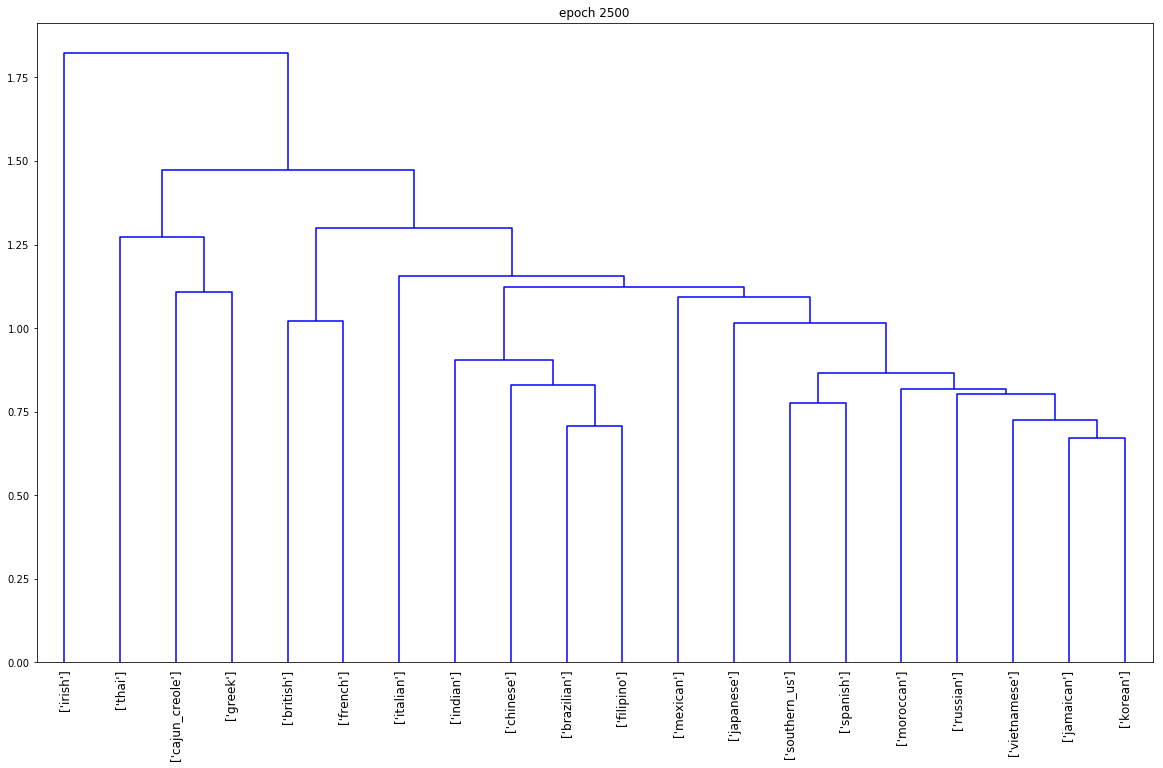

In [69]:
plot_dendo(rep1[:20], rep2[:20], rep3[:20], cuisine_names, x_rotation = 90)

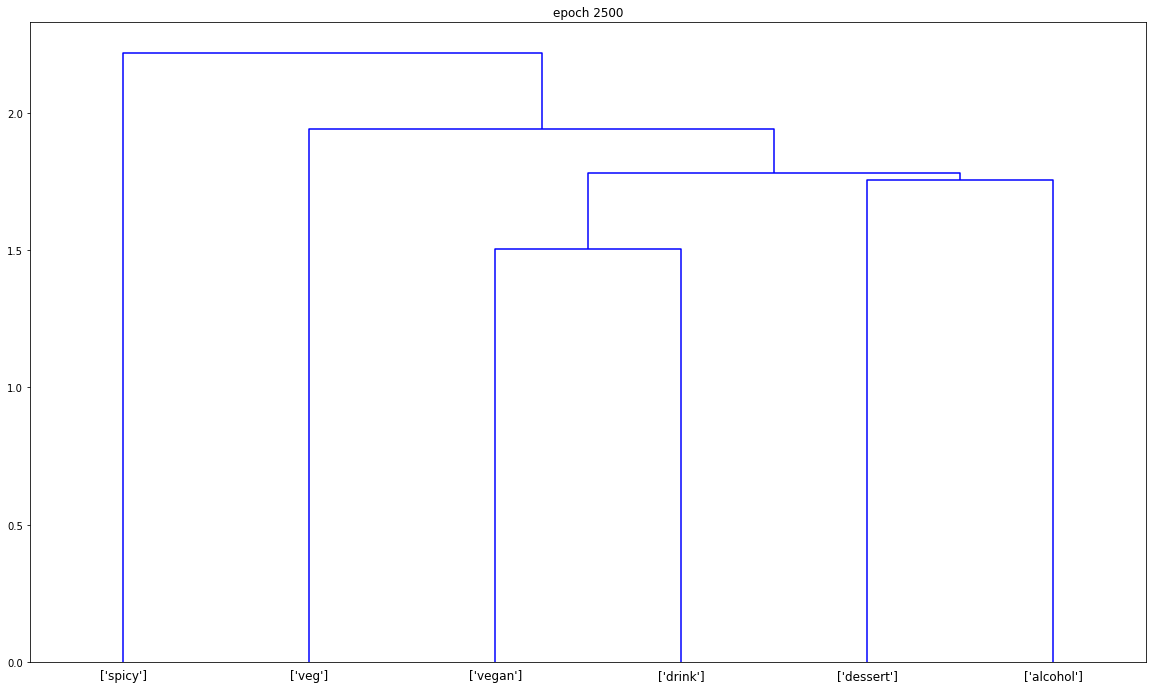

In [70]:
plot_dendo(rep1[20:], rep2[20:], rep3[20:], descriptor_names)

In [71]:
cuisine_names[5]

array(['french'], dtype=object)

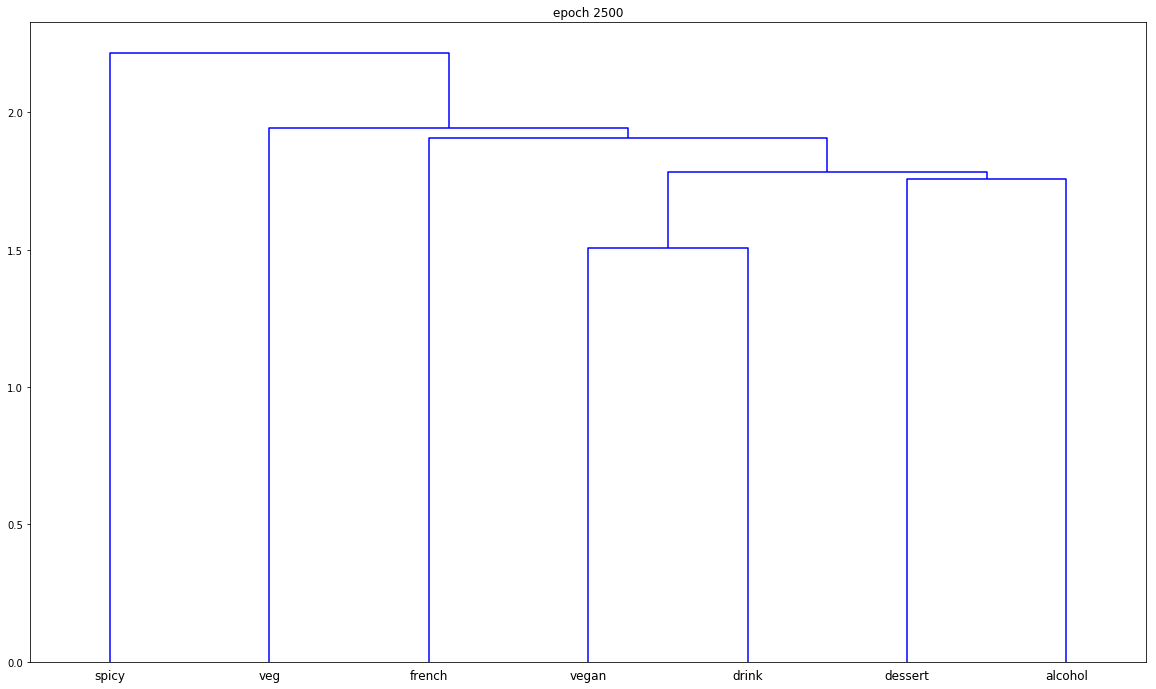

In [72]:
plot_dendo(rep1[[5, 20, 21, 22, 23, 24, 25], :], 
           rep2[[5, 20, 21, 22, 23, 24, 25], :], 
           rep3[[5, 20, 21, 22, 23, 24, 25], :], np.append(cuisine_names[5], descriptor_names))



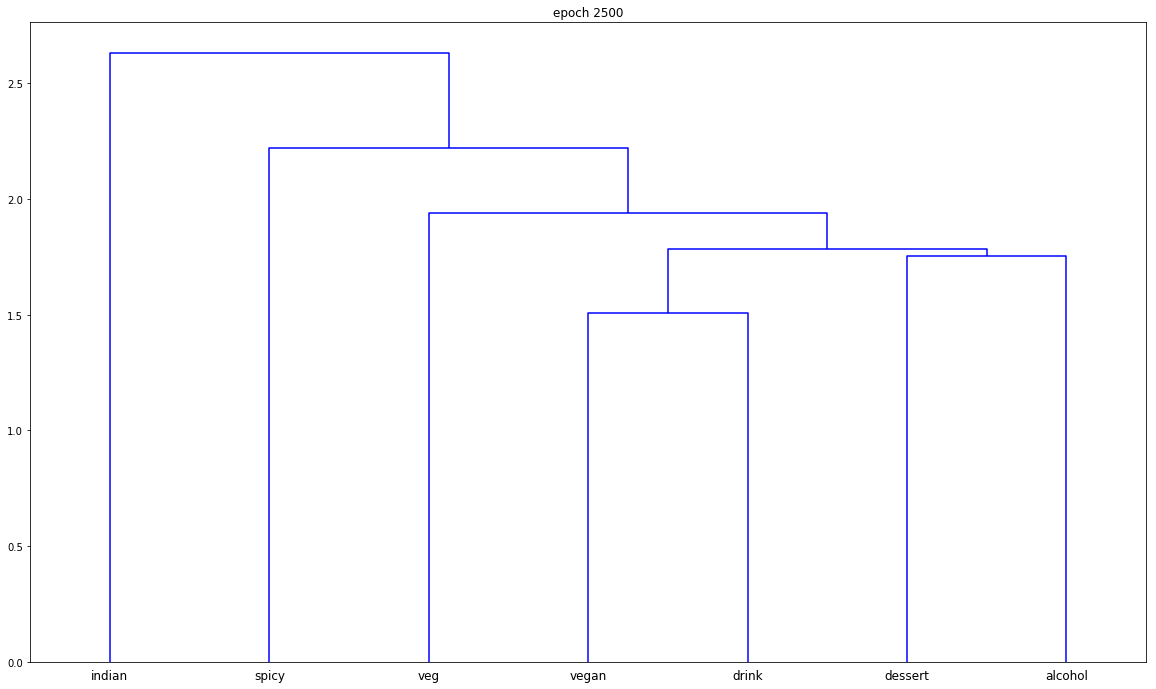

In [73]:
plot_dendo(rep1[[7, 20, 21, 22, 23, 24, 25], :], 
           rep2[[7, 20, 21, 22, 23, 24, 25], :], 
           rep3[[7, 20, 21, 22, 23, 24, 25], :], np.append(cuisine_names[7], descriptor_names))